### Demo for using Interproc b/w guiview <=> Ipython

In [1]:
import os, sys, copy
sys.path.append("../")
%load_ext autoreload
%autoreload 2
import cv2
import numpy as np
import pickle
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# we'll reload these occasionally
from modules.Interproc import GuiviewState
from modules.Interproc import DBInterface
from modules.ControlTracking import TrackFactory
from modules.ControlDisplay import Display

## Example retreiving a GuiviewState from DB

GuiviewState is loaded with serialized str: 921738


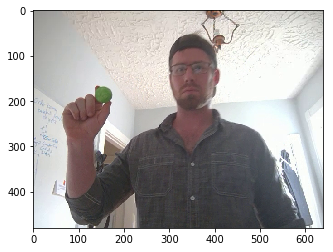

In [4]:
db = DBInterface("../data/usr/interproc.db")

record = db.selectLatest()
gs = pickle.loads(record[0][1])

print '%s is loaded with serialized str: %s' % (gs.__class__.__name__, 
                                            str(len(gs.serial_origFrame))
                                               )

plt.imshow(gs.getOrigFrame(b_cvt_color = True))

In [ ]:
#TODOs
# [ ] try with large image
# [x] import tracking logic

### Build your List

In [427]:
# INIT ONCE HERE
listGS = []

In [428]:
# Run this each time you do guiview:state-output
# currently frames: 0, 198, 312
listGS.append( pickle.loads(db.selectLatest()[0][1]) )

### Helper Functions

In [365]:
def buildData(listGS, tracker):
    ''' 
        we look at respective zoomWindow for each step in 
        the track pipeline. TODO - better description
    '''
    
    listData = []
    listScore = []
    listPlts = []
    listTransformTitles = []
    listFrameTitles = []

    for _gs in listGS:

        _gs.initDisplay()

        zoomImg = _gs.getZoomWindow()

        tracker.setFrame(zoomImg)

        listData.append( tracker.trackFrame(b_log=True) )

        listScore.append( tracker.getTrackScore())

        listFrameTitles.append( str(_gs.frameCounter) )

    for _data in listData:

        for _key in _data.keys():

            try:
                assert _data[_key].shape[0] > 0
                assert _data[_key].shape[1] > 0
            except:
                continue     # not an image; bypass

            # build list of all keys in all tracking scenarios;
            # this way we'll include a record for that transform 
            # for each Frame for an NxM-aligned subplots
            
            if _key not in listTransformTitles:
                listTransformTitles.append(_key)
        
    for _data in listData:
    
        listTmp = []
        
        for _transformTitle in listTransformTitles:
            
            # inclue the image-data from this transform;
            # if that transform doesn't exist, mark as None.
            
            try:
                outputData = _data[_transformTitle]
            except:
                outputData = None
                
            listTmp.append( outputData )

        listPlts.append( listTmp )
    
    ret = {}
    ret['listPlts'] = listPlts
    ret['listScore'] = listScore
    ret['listFrameTitles'] = listFrameTitles
    ret['listTransformTitles'] = listTransformTitles
                            
    return ret

In [423]:
def multiPlot(list_list_imgs
              ,b_cvt_color = True
              ,input_transform_titles = None
              ,input_frame_titles = None
              ,input_figure_title = None
              ,figsize = (10,10)
              
             ):
    
    #TODO - b_flip
    w = len(list_list_imgs)
    h = len(list_list_imgs[0])     
    
    b_multiline = False
    if (h > 1) and (w > 1):
        b_multiline = True
    
    fig, ax = plt.subplots(h,w, figsize=figsize)
    
    fig.subplots_adjust(hspace=0.3)
    
    if input_figure_title is not None:
        fig.suptitle(input_figure_title)
    
    for h_i in range(h):
        for w_i in range(w):
            
            if list_list_imgs[w_i][h_i] is None:
                continue
                
            _img = list_list_imgs[w_i][h_i]
            _img = GuiviewState.cvtColor(_img.copy())
            
            if b_multiline:
                _ax = ax[h_i][w_i]
            else:
                _ax = ax[(h_i * w_i) + w_i]
                
            _ax.imshow(_img)
            
            if input_transform_titles is not None:
                if (not(b_multiline) or w_i == 0) :
                    _ax.set_ylabel(input_transform_titles[h_i])
                    
            if input_frame_titles is not None:
                if (not(b_multiline) or h_i == 0) :
                    _ax.set_title(input_frame_titles[w_i])
    
    fig.show()

## Build Debug Plots

#### Plot at default track params

{'thresh_hi': (64, 255, 255), 'thresh_lo': (29, 86, 6), 'tracking_blur': 1, 'repair_iterations': 1}


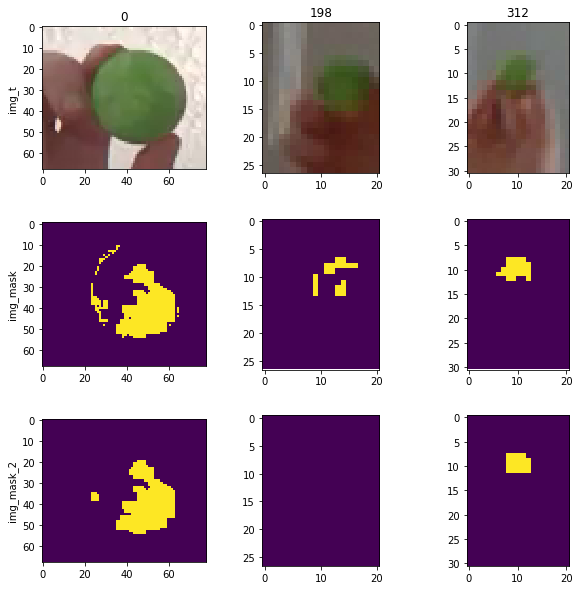

In [366]:
myTracker = TrackFactory(on=True)
myTracker.setInit(ballColor = "green")
print myTracker.getTrackParams()

ret = buildData(listGS, myTracker)

multiPlot(  ret['listPlts']
           ,input_frame_titles=ret['listFrameTitles'] 
           ,input_transform_titles=ret['listTransformTitles']
         )

#### Plot with alternative trackAlgo; no repair iters

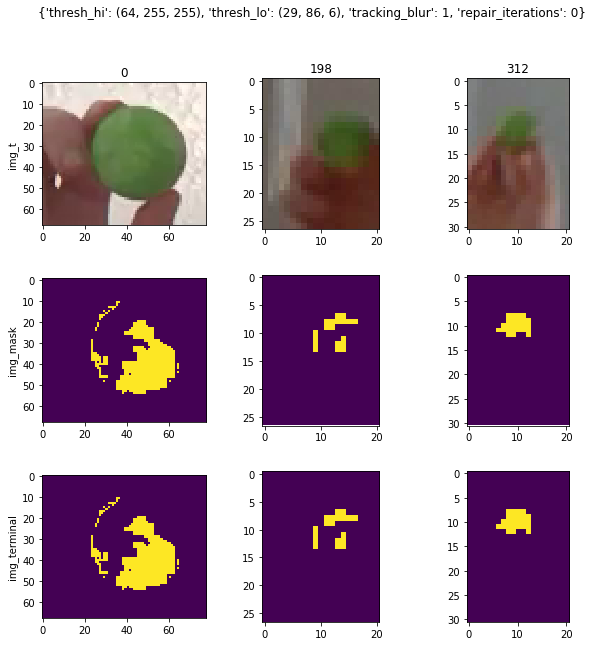

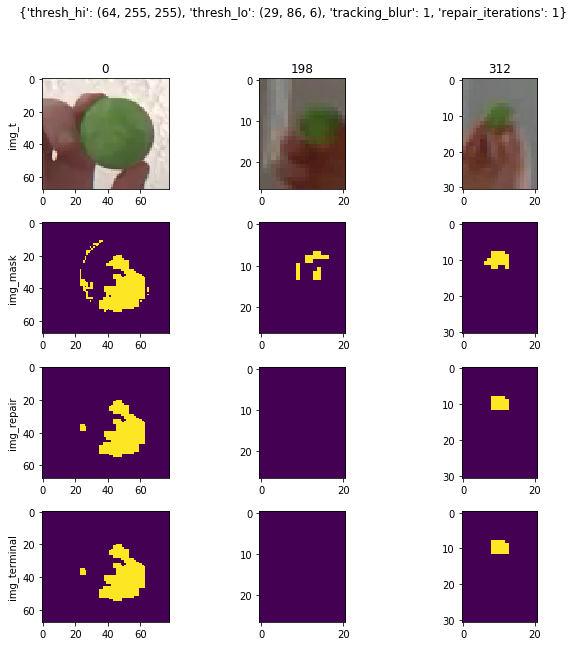

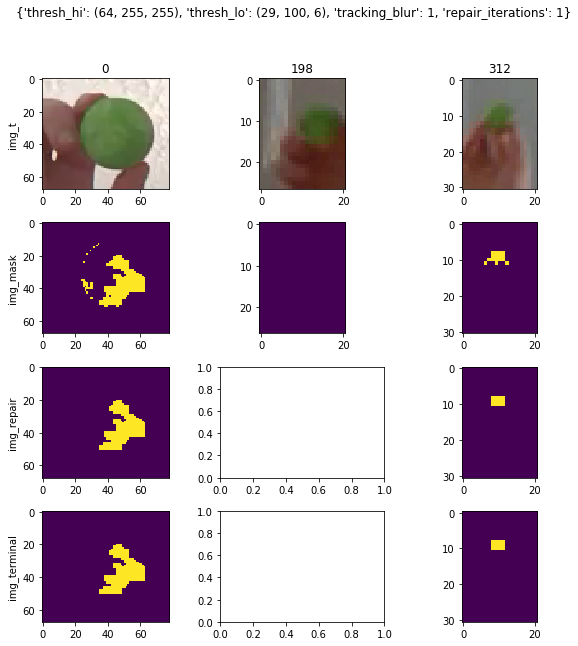

In [422]:
myTracker4 = TrackFactory(on=True)
myTracker4.setInit(ballColor = "green")
myTracker4.setAlgoEnum(1)
myTracker4.setTrackParams(repair_iterations = 0)

ret = buildData(listGS, myTracker4)

multiPlot(  ret['listPlts']
           ,input_frame_titles=ret['listFrameTitles'] 
           ,input_transform_titles=ret['listTransformTitles']
           ,input_figure_title = str(myTracker4.getTrackParams())
         )


# some stringent
myTracker4.setTrackParams(repair_iterations = 1)

ret = buildData(listGS, myTracker4)

multiPlot(  ret['listPlts']
           ,input_frame_titles=ret['listFrameTitles'] 
           ,input_transform_titles=ret['listTransformTitles']
           ,input_figure_title = str(myTracker4.getTrackParams())
         )

# very stringent 
myTracker4.setTrackParams(thresh_lo = (29,100,6))

ret = buildData(listGS, myTracker4)

multiPlot(  ret['listPlts']
           ,input_frame_titles=ret['listFrameTitles'] 
           ,input_transform_titles=ret['listTransformTitles']
           ,input_figure_title = str(myTracker4.getTrackParams())
         )

# this should show multiPlot() can handle img-data=None in some cases:

# check that there is a None element in the listPlts, symbolizing 
# that buildData() did not receive this plt-data from trackFrame()
# but included a space nonetheless

assert ret['listPlts'][1][2] is None

#### Plot at liberal track params

In [361]:
myTracker2 = TrackFactory(on=True)
myTracker2.setInit(ballColor = "green")
myTracker2.getTrackParams()

{'repair_iterations': 1,
 'thresh_hi': (64, 255, 255),
 'thresh_lo': (29, 86, 6),
 'tracking_blur': 1}

In [362]:
myTracker2.setTrackParams(thresh_lo = (29,76,6))
myTracker2.getTrackParams()

{'repair_iterations': 1,
 'thresh_hi': (64, 255, 255),
 'thresh_lo': (29, 76, 6),
 'tracking_blur': 1}

{'thresh_hi': (64, 255, 255), 'thresh_lo': (29, 76, 6), 'tracking_blur': 1, 'repair_iterations': 1}


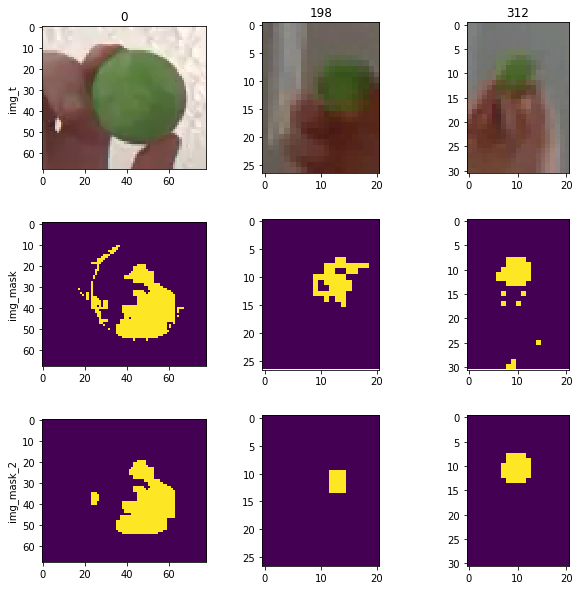

In [364]:
ret = buildData(listGS, myTracker2)

print myTracker2.getTrackParams()

multiPlot(  ret['listPlts']
           ,input_frame_titles=ret['listFrameTitles'] 
           ,input_transform_titles=ret['listTransformTitles']
         )

#### Plot at overly conservative track params

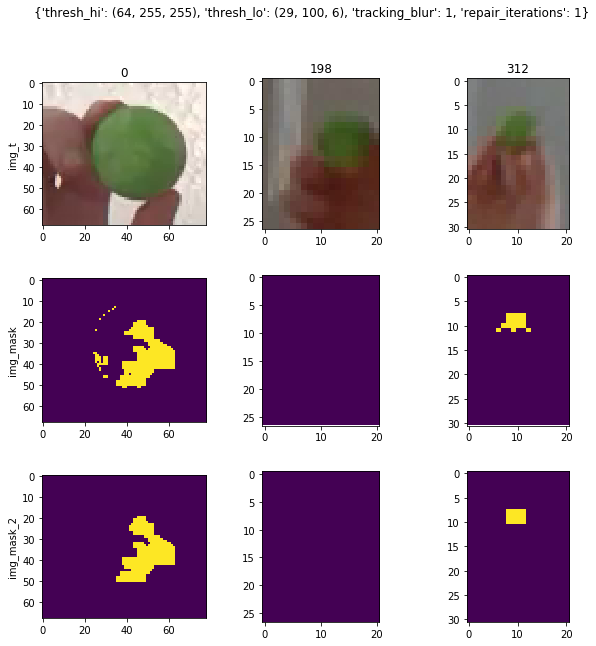

In [419]:
myTracker3 = TrackFactory(on=True)
myTracker3.setInit(ballColor = "green")

myTracker3.setTrackParams(thresh_lo = (29,100,6))

ret = buildData(listGS, myTracker3)

multiPlot(  ret['listPlts']
           ,input_frame_titles=ret['listFrameTitles'] 
           ,input_transform_titles=ret['listTransformTitles']
           ,input_figure_title = str(myTracker3.getTrackParams())
         )

IND = 1
number_of_nones = filter(lambda x: x, 
                           [elem is None for elem in ret['listPlts'][IND]]
                        )

### Using Display (experimental)

In [425]:
from modules.ControlDisplay import Display

_display = Display()

_display.setInit(showOn=False
                ,scoreOff=False
                ,frameResize=True
                ,frameAnnotateFn=False)

_display.setFrame(badImg)

_display.setTrack(trackScore = track.getTrackScore())

_display.alterFrame()
_display.drawOperators()
_display.drawTrackers()